In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.preprocessing import Normalizer
import cv2

In [2]:
def extract_good_values(frame):
    blurred = cv2.blur(frame, (3,3))
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    retval, bw_img = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
    
    #import pdb
    #pdb.set_trace()
    
    cnts, _ = cv2.findContours(bw_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    point_list = []
    
    for num, contour in enumerate(cnts):
        #print(contour)
        M = cv2.moments(contour)
        if (M["m00"] != 0):
            x_c = int(M["m10"] / M["m00"])
            y_c = int(M["m01"] / M["m00"])
        else:
            x_c = -1
            y_c = -1
        retval = cv2.arcLength(contour, True)
        points = cv2.approxPolyDP(contour, 0.04 * retval, True)
        if len(points) == 5:  # additional filter here
            point_list.append(points.reshape((5,2)))

        
    return point_list
        
        
        

In [3]:
def extract_hull_and_contour(frame):
    blurred = cv2.blur(frame, (3,3))
    gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
    retval, bw_img = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
    
    #import pdb
    #pdb.set_trace()
    
    cnts, _ = cv2.findContours(bw_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)
    
    point_list = []
    contour_list = []
    
    for num, contour in enumerate(cnts):
        #print(contour)
        M = cv2.moments(contour)
        if (M["m00"] != 0):
            x_c = int(M["m10"] / M["m00"])
            y_c = int(M["m01"] / M["m00"])
        else:
            x_c = -1
            y_c = -1
        retval = cv2.arcLength(contour, True)
        points = cv2.approxPolyDP(contour, 0.04 * retval, True)
        if len(points) == 5:  # additional filter here
            point_list.append(points.reshape((5,2)))
            contour_list.append(contour)
        
    return point_list, contour_list

In [4]:
def ranges_and_angles(shape):
    min_rect = cv2.minAreaRect(shape)
    length_reference = np.max(min_rect[1])
    
    M = cv2.moments(shape)
    x_c = int(M['m10'] / M['m00'])
    y_c = int(M['m01'] / M['m00'])
    
    ranges = np.zeros(len(shape))
    angles = np.zeros(len(shape))
    
    for pos in range(len(shape)):
        next_pos = (pos + 1) % len(shape)
        
        d_x_current = shape[pos][0] - x_c
        d_y_current = shape[pos][1] - y_c
        
        d_x_next = shape[next_pos][0] - x_c
        d_y_next = shape[next_pos][1] - y_c
        
        norm_range = np.sqrt(np.power(d_x_current, 2) + np.power(d_y_current, 2)) / length_reference
        
        first_abs_angle = np.angle(d_x_current + d_y_current * 1j, deg=True)
        second_abs_angle = np.angle(d_x_next + d_y_next * 1j, deg=True)
        delta_angle = second_abs_angle - first_abs_angle
        
        if delta_angle < 0:
            delta_angle += 360
            
        norm_delta_angle = delta_angle / 360
        
        ranges[pos] = norm_range
        angles[pos] = norm_delta_angle

    return ranges, angles

# extract from file

In [70]:
img = cv2.imread('/home/me/Programmierung/AI_Test/find_arrow_symbol/detect_arrow/50_cm.jpg')
blurred = cv2.blur(img, (3,3))
gray = cv2.cvtColor(blurred, cv2.COLOR_BGR2GRAY)
retval, bw_img = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY)
cnts, _ = cv2.findContours(bw_img, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE)  # arrow seems to be internal

point_list = []

for num, contour in enumerate(cnts):
    M = cv2.moments(contour)
    if (M["m00"] != 0):
        x_c = int(M["m10"] / M["m00"])
        y_c = int(M["m01"] / M["m00"])
    else:
        x_c = -1
        y_c = -1
    retval = cv2.arcLength(contour, True)
    points = cv2.approxPolyDP(contour, 0.04 * retval, True)
    print(len(points))
    if len(points) == 5:
        point_list.append(points.reshape((5,2)))
        
    #return (points, x_c, y_c)
print('#######')
print(len(point_list))


5
4
1
9
1
5
6
6
6
5
6
7
4
8
7
6
6
4
6
1
4
6
5
#######
4


In [50]:
for num in range(len(point_list)):
    if len(point_list[num]) == 5:
        img2 = np.zeros((480, 640,3))
        cv2.drawContours(img2, cnts, num, (0,0,255), thickness=10)
        #cv2.imshow('orig', img)
        cv2.imshow('test', img2)
        cv2.waitKey(0)
cv2.destroyAllWindows()

In [95]:
arr = np.array(point_list)
np.save('test', arr)


In [97]:
arr2 = np.load('test.npy')

In [98]:
arr.shape

(4, 5, 2)

In [99]:
arr2.shape

(4, 5, 2)

# extract from video for the first time

In [2]:
video_path = '/home/me/Videos/Kamera/2023-09-01-163208.webm'

In [11]:
found_shapes_raw = []
wrong_shapes_raw = []

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    cap.release()
    raise SystemExit()
    
frameRate = cap.get(5) #frame rate
abort = False

while cap.isOpened():
    frameId = cap.get(1) #current frame number
    ret, frame = cap.read()
    if ret == True:
 
        # Display the resulting frame
        cv2.imshow('Frame',frame)
 
        key = cv2.waitKey(25) & 0xFF
    
        # Press Q on keyboard to  exit
        if key == ord('q') or abort:
            break
        elif frameId % np.floor(frameRate) == 0:
            try:
                values = extract_good_values(frame)
            except:
                print('an error occurred')
                raise SystemExit()
                
            for num, features in enumerate(values):
                con_frame = frame.copy()
                cv2.drawContours(con_frame, values, num, (0,0,255), thickness=10)
                cv2.imshow('Frame',con_frame)
                key = cv2.waitKey(0) & 0xFF
                if key == ord('n'):
                    wrong_shapes_raw.append(features)
                elif key == ord('y'):
                    found_shapes_raw.append(features)
                elif key == ord('q'):
                    abort = True
                    break
                    
                
    # Break the loop
    else: 
        break
 
# When everything done, release the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

good_values = np.array(found_shapes_raw)
bad_values = np.array(wrong_shapes_raw)
np.save('good_values', good_values)
np.save('bad_values', bad_values)
print('done')


done


In [8]:
cv2.destroyAllWindows()
cap.release()

In [12]:
cap.isOpened()

False

In [13]:
loaded_good_values = np.load('good_values.npy')

In [14]:
loaded_good_values.shape

(121, 5, 2)

# minAreaRect, transform, scaling, ...

## get better shape data

In [11]:
shape_reference = np.load('shape_reference.npy')

In [12]:
M = cv2.moments(shape_reference)
x_c = int(M["m10"] / M["m00"])
y_c = int(M["m01"] / M["m00"])
retval = cv2.arcLength(shape_reference, True)
points = cv2.approxPolyDP(shape_reference, 0.04 * retval, True)

In [13]:
x_c

302

In [14]:
y_c

223

In [15]:
M = cv2.moments(points)
xp_c = int(M['m10'] / M['m00'])
yp_c = int(M['m01'] / M['m00'])



In [16]:
xp_c

302

In [17]:
yp_c

220

In [24]:
np.save('shape_reference_points', points)

In [10]:
points = np.load('shape_reference_points.npy')

In [11]:
reference_rect = cv2.minAreaRect(points)
# x,y,w,h = cv.boundingRect(cnt)
# center (x,y), (width, height), angle of rotation ( 90 degree is up), negative values possible
# center (x,y), (width, height), angle of rotation ( 90 degree is up), negative values possible
ref_box = cv2.boxPoints(reference_rect)
ref_box = np.intp(ref_box)

In [23]:
reference_rect

((291.92498779296875, 218.60198974609375),
 (135.26010131835938, 409.2398376464844),
 6.668918609619141)

In [24]:
black = np.zeros((480, 640, 4))
cv2.drawContours(black, points, -1, (255, 0, 0), thickness=10)
cv2.drawContours(black, [ref_box], -1, (0, 0, 255), thickness=5)
cv2.imshow('shape_reference', black)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [26]:
np.save('shape_reference_width_and_height', reference_rect[1])

In [27]:
ref_width, ref_height = np.load('shape_reference_width_and_height.npy')

In [28]:
ref_width

135.26010131835938

In [29]:
ref_height

409.2398376464844

## example

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.preprocessing import Normalizer
import cv2

In [2]:
loaded_good_values = np.load('good_values.npy')

In [3]:
good_raw_features = loaded_good_values[0] 

In [4]:
good_raw_features

array([[266, 139],
       [322, 135],
       [386, 361],
       [339, 451],
       [269, 380]], dtype=int32)

In [5]:
min_rect = cv2.minAreaRect(good_raw_features)
# center (x,y), (width, height), angle of rotation ( 90 degree is up, clockwise), negative values possible
min_rect

((326.535888671875, 293.0493469238281),
 (316.1871337890625, 117.22742462158203),
 89.28681945800781)

In [9]:
box = cv2.boxPoints(min_rect)
box = np.intp(box)

In [7]:
test_rect = (*min_rect[:2], 45)
box = cv2.boxPoints(test_rect)
box = np.intp(box)

In [10]:
black = np.zeros((480, 640, 4))
cv2.drawContours(black, [good_raw_features], -1, (255, 0, 0), thickness=5)
cv2.drawContours(black,[box],0,(0,0,255),2)
cv2.imshow('example', black)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [31]:
ranges, angles = ranges_and_angles(good_raw_features)
print(ranges)
print(angles)
result = np.hstack((ranges, angles))
result

[0.50907425 0.49690386 0.31086143 0.50810072 0.3155243 ]
[0.05634955 0.36777562 0.10328116 0.10093679 0.37165687]


array([0.50907425, 0.49690386, 0.31086143, 0.50810072, 0.3155243 ,
       0.05634955, 0.36777562, 0.10328116, 0.10093679, 0.37165687])

In [33]:
# create normalized values
good_norm_values = np.zeros((loaded_good_values.shape[0], loaded_good_values.shape[1] * 2))
for pos, contour in enumerate(loaded_good_values):
    ranges, angles = ranges_and_angles(contour)
    result = np.hstack((ranges, angles))
    good_norm_values[pos][:] = result

In [34]:
good_norm_values

array([[0.50907425, 0.49690386, 0.31086143, ..., 0.10328116, 0.10093679,
        0.37165687],
       [0.51273755, 0.50441431, 0.31878568, ..., 0.10230687, 0.10389935,
        0.37489062],
       [0.51870891, 0.50875674, 0.31551754, ..., 0.09345938, 0.09968176,
        0.38334469],
       ...,
       [0.53008605, 0.33005411, 0.4961722 , ..., 0.09001262, 0.38104096,
        0.04348312],
       [0.52081843, 0.49040569, 0.32581401, ..., 0.08971785, 0.0979132 ,
        0.38013225],
       [0.51614876, 0.49296604, 0.31046361, ..., 0.10313591, 0.10619184,
        0.3684691 ]])

In [35]:
good_norm_values.shape

(121, 10)

In [36]:
np.save('good_norm_values', good_norm_values)

In [3]:
loaded_good_norm_values = np.load('good_norm_values.npy')

In [40]:
loaded_bad_values = np.load('bad_values.npy')

In [41]:
# create normalized values
bad_norm_values = np.zeros((loaded_bad_values.shape[0], loaded_bad_values.shape[1] * 2))
for pos, contour in enumerate(loaded_bad_values):
    ranges, angles = ranges_and_angles(contour)
    result = np.hstack((ranges, angles))
    bad_norm_values[pos][:] = result

In [42]:
bad_norm_values

array([[0.65446119, 0.34493133, 0.37150241, ..., 0.11564872, 0.39758362,
        0.97741638],
       [0.5       , 0.5       , 0.5       , ..., 0.        , 0.875     ,
        0.875     ],
       [0.48892552, 0.13560354, 0.60643747, ..., 0.80120819, 0.92620819,
        0.85520829],
       ...,
       [0.56819628, 0.35140632, 0.45109473, ..., 0.90892397, 0.84016136,
        0.71162686],
       [0.53571791, 0.3659078 , 0.18105617, ..., 0.70873695, 0.78059751,
        0.71747682],
       [0.50026382, 0.66616597, 0.10936423, ..., 0.26371028, 0.85927884,
        0.63157063]])

In [44]:
bad_norm_values.shape

(306, 10)

In [45]:
np.save('bad_norm_values', bad_norm_values)

In [4]:
loaded_bad_norm_values = np.load('bad_norm_values.npy')

# prepare model

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
#from sklearn.preprocessing import Normalizer
import cv2

In [3]:
loaded_good_norm_values = np.load('good_norm_values.npy')

In [4]:
loaded_bad_norm_values = np.load('bad_norm_values.npy')

In [5]:
loaded_good_norm_values

array([[0.50907425, 0.49690386, 0.31086143, ..., 0.10328116, 0.10093679,
        0.37165687],
       [0.51273755, 0.50441431, 0.31878568, ..., 0.10230687, 0.10389935,
        0.37489062],
       [0.51870891, 0.50875674, 0.31551754, ..., 0.09345938, 0.09968176,
        0.38334469],
       ...,
       [0.53008605, 0.33005411, 0.4961722 , ..., 0.09001262, 0.38104096,
        0.04348312],
       [0.52081843, 0.49040569, 0.32581401, ..., 0.08971785, 0.0979132 ,
        0.38013225],
       [0.51614876, 0.49296604, 0.31046361, ..., 0.10313591, 0.10619184,
        0.3684691 ]])

In [6]:
loaded_good_norm_values.shape

(121, 10)

In [7]:
loaded_bad_norm_values.shape

(306, 10)

In [8]:
combined_norm_values = np.concatenate((loaded_good_norm_values, loaded_bad_norm_values), dtype=np.float32)

In [9]:
combined_norm_values.shape

(427, 10)

In [10]:
good_labels = np.ones(loaded_good_norm_values.shape[0], dtype=int)
bad_labels = np.zeros(loaded_bad_norm_values.shape[0], dtype=int)

In [11]:
good_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [12]:
combined_labels = np.concatenate((good_labels, bad_labels))

In [13]:
combined_labels.shape

(427,)

In [14]:
loaded_good_values = np.load('good_values.npy')
loaded_bad_values = np.load('bad_values.npy')

In [16]:
raw_values = np.concatenate((loaded_good_values, loaded_bad_values))

In [17]:
raw_values.shape

(427, 5, 2)

In [18]:
from sklearn.model_selection import train_test_split

In [20]:
prepared_train_values, prepared_test_values, prepared_train_labels, prepared_test_labels, raw_train_values, raw_test_values = train_test_split(
    combined_norm_values, 
    combined_labels,
    raw_values,
    test_size=0.33, 
    random_state=42
)

In [21]:
prepared_train_values.shape

(286, 10)

In [22]:
prepared_train_labels.shape

(286,)

In [23]:
raw_train_values.shape

(286, 5, 2)

# training

In [78]:
# Train the SVM
svm = cv2.ml.SVM_create()
svm.setType(cv2.ml.SVM_C_SVC)
svm.setKernel(cv2.ml.SVM_RBF)
svm.setTermCriteria((cv2.TERM_CRITERIA_MAX_ITER, 1_000_000, 1e-6))

In [79]:
svm.train(prepared_train_values, cv2.ml.ROW_SAMPLE, prepared_train_labels)

True

In [85]:
svm.save('trained_arrow_detection.yml')

In [86]:
svm = cv2.ml.SVM_load('trained_arrow_detection.yml')

In [41]:
prepared_test_values[0]

array([0.49614337, 0.42470527, 0.48049918, 0.5830549 , 0.49141604,
       0.8453617 , 0.7274164 , 0.8250857 , 0.6806368 , 0.9214994 ],
      dtype=float32)

In [43]:
np.matrix(prepared_test_values[0])

matrix([[0.49614337, 0.42470527, 0.48049918, 0.5830549 , 0.49141604,
         0.8453617 , 0.7274164 , 0.8250857 , 0.6806368 , 0.9214994 ]],
       dtype=float32)

In [47]:
np.matrix(prepared_test_values[0]).shape

(1, 10)

In [28]:
response = svm.predict(np.matrix(prepared_test_values[0]))

In [29]:
response

(0.0, array([[1.]], dtype=float32))

In [30]:
for element in response:
    print(element)

0.0
[[1.]]


In [31]:
response[0]

0.0

In [32]:
response[1]

array([[1.]], dtype=float32)

In [33]:
response[1][0][0]

1.0

In [36]:
responses[0]

0.0

In [88]:
#responses = svm.predict(prepared_test_values)
#for position, label in enumerate(prepared_test_labels):
#    if responses[1][position] != label:
#        print(f'response:{responses[1][position]} but label {label} -- position {position}')

#responses = svm.predict(prepared_train_values)
#for position, label in enumerate(prepared_train_labels):
#    if responses[1][position] != label:
#        print(f'response:{responses[1][position]} but label {label} -- position {position}')
        
responses = svm.predict(combined_norm_values)
for position, label in enumerate(combined_labels):
    if responses[1][position] != label:
        print(f'response:{responses[1][position]} label {label} -- position {position}')



response:[1.] label 0 -- position 144
response:[1.] label 0 -- position 165
response:[1.] label 0 -- position 193
response:[1.] label 0 -- position 203
response:[1.] label 0 -- position 212
response:[1.] label 0 -- position 219
response:[1.] label 0 -- position 227
response:[1.] label 0 -- position 232
response:[1.] label 0 -- position 258
response:[1.] label 0 -- position 271
response:[1.] label 0 -- position 276
response:[1.] label 0 -- position 282
response:[1.] label 0 -- position 283
response:[1.] label 0 -- position 307
response:[1.] label 0 -- position 308
response:[1.] label 0 -- position 310
response:[1.] label 0 -- position 317
response:[1.] label 0 -- position 319
response:[1.] label 0 -- position 325
response:[1.] label 0 -- position 333
response:[1.] label 0 -- position 334
response:[1.] label 0 -- position 339
response:[1.] label 0 -- position 347
response:[1.] label 0 -- position 349
response:[1.] label 0 -- position 354
response:[1.] label 0 -- position 358
response:[1.

In [89]:
blue = (255, 0, 0)
red = (0, 0, 255)
for num, con in enumerate(raw_values):
    black = np.zeros((480, 640, 4))

    if combined_labels[num] == 1:
        color = blue
    else:
        color = red
        
    if responses[1][num] == 1:
        color1 = blue
    else:
        color1 = red
        
    cv2.drawContours(black, [con], -1, color1, thickness=10)
    cv2.drawContours(black, [con], -1, color, thickness=3)


    cv2.imshow('example', black)
    key = cv2.waitKey(0)
    if key == ord('q') or key == 27:  # ESC
        break
        
cv2.destroyAllWindows()

In [83]:
blue = (255, 0, 0)
red = (0, 0, 255)
for num, con in enumerate(raw_test_values):
    black = np.zeros((480, 640, 4))

    if prepared_test_labels[num] == 1:
        color = blue
    else:
        color = red
        
    if responses[1][num] == 1:
        color1 = blue
    else:
        color1 = red
        
    cv2.drawContours(black, [con], -1, color1, thickness=10)
    cv2.drawContours(black, [con], -1, color, thickness=3)


    cv2.imshow('example', black)
    key = cv2.waitKey(0)
    if key == ord('q') or key == 27:  # ESC
        break
        
cv2.destroyAllWindows()

In [107]:
prepared_test_labels[0]

0

In [104]:
response = svm.predict(np.matrix(prepared_train_values[0]))

In [105]:
response

(0.0, array([[1.]], dtype=float32))

In [106]:
prepared_train_labels[0]

1

In [90]:
test_img = cv2.imread('/home/me/Bilder/Bildschirmfotos/Bildschirmfoto vom 2023-09-10 20-07-58.png')

In [94]:
point_list = extract_good_values(test_img)

In [95]:
point_list = np.array(point_list)

In [96]:
# create normalized values
norm_values = np.zeros((point_list.shape[0], point_list.shape[1] * 2))
for pos, contour in enumerate(point_list):
    ranges, angles = ranges_and_angles(contour)
    result = np.concatenate((ranges, angles))
    norm_values[pos][:] = result

In [97]:
norm_values

array([[0.43448304, 0.35714286, 0.41649656, 0.57587555, 0.22587698,
        0.87129939, 0.68842682, 0.93378128, 0.78141648, 0.72507604],
       [0.52235221, 0.50284322, 0.31877771, 0.50029476, 0.31745804,
        0.04847787, 0.37988376, 0.09443678, 0.09185247, 0.38534913]])

In [99]:
for features in norm_values:
    result = svm.predict(np.matrix(features, dtype=np.float32))
    print(result)

(0.0, array([[0.]], dtype=float32))
(0.0, array([[1.]], dtype=float32))


In [108]:
#black = np.zeros((480, 640, 4))
#for con in point_list:
#    cv2.drawContours(black, [con], -1, (255, 0, 0), thickness=5)
cv2.drawContours(test_img, [point_list[1]], -1, (255, 0, 0), thickness=5)

cv2.imshow('example', test_img)
cv2.waitKey(0)
cv2.destroyAllWindows()

# collect more data

In [7]:
# import
# def extract_good_values
# def ranges_and_angles
# load svm
# get file path
# start file reading
# guess and approve shape

In [4]:
svm = cv2.ml.SVM_load('trained_arrow_detection.yml')

In [5]:
video_path = '/home/me/Videos/Kamera/2023-09-01-163208.webm'

In [17]:
def check_contours_manually(values, frame, color, wrong_shapes_raw, found_shapes_raw):
    tmp_bad_shapes_raw = []
    tmp_good_shapes_raw = []
    
    for num, features in enumerate(values):
        con_frame = frame.copy()
        cv2.drawContours(con_frame, values, num, color, thickness=10)
        cv2.imshow('Frame',con_frame)
        key = cv2.waitKey(0) & 0xFF
        if key == ord('n'):
            tmp_bad_shapes_raw.append(features)
        elif key == ord('y'):
            tmp_good_shapes_raw.append(features)
        elif key == ord('q'):
            return True
        elif key == ord('r'):
            return check_contours_manually(values, frame, color, wrong_shapes_raw, found_shapes_raw)
        
    wrong_shapes_raw.extend(tmp_bad_shapes_raw)
    found_shapes_raw.extend(tmp_good_shapes_raw)
    return False

In [18]:
from datetime import datetime
from datetime import timezone

found_shapes_raw = []
wrong_shapes_raw = []

cap = cv2.VideoCapture(video_path)

if not cap.isOpened():
    cap.release()
    raise SystemExit()
    
frameRate = cap.get(5) #frame rate
abort = False

while cap.isOpened():
    frameId = cap.get(1)
    ret, frame = cap.read()
    if ret == True:
 
        # Display the resulting frame
        cv2.imshow('Frame',frame)
 
        key = cv2.waitKey(25) & 0xFF
    
        # Press Q on keyboard to  exit
        if key == ord('q') or abort:
            break
        elif frameId % np.floor(frameRate) == 0:
            try:
                values = extract_good_values(frame)
            except:
                print('an error occurred')
                raise SystemExit()
            
            # prediction
            red = (0, 0, 255)
            blue = (255, 0, 0)
            purple = (255, 0, 255)
            
            bad_predicted_values = []
            good_predicted_values = []
            
            for num, features in enumerate(values):
                con_frame = frame.copy()
                
                ranges, angles = ranges_and_angles(features)
                prepared_values = np.concatenate((ranges, angles))
                try:
                    result = svm.predict(np.matrix(prepared_values, dtype=np.float32))[1][0]
                except Exception as e:
                    print(e)
                    break
                    
                if result == 1:
                    #color = blue
                    good_predicted_values.append(features)  # only last good is shown
                else:
                    #color = red
                    bad_predicted_values.append(features)
                    
            if good_predicted_values:
                cv2.drawContours(con_frame, good_predicted_values, -1, blue, thickness=10)
                cv2.drawContours(con_frame, bad_predicted_values, -1, red, thickness=10)
                
                if len(good_predicted_values) > 1:
                    cv2.putText(con_frame, f'many good values found; len(good val)={len(good_predicted_values)}', (10,460), cv2.FONT_HERSHEY_SIMPLEX, .5, red)    
                else:
                    cv2.putText(con_frame, f'one good values found; len(good val)={len(good_predicted_values)}', (10,460), cv2.FONT_HERSHEY_SIMPLEX, .5, blue)    
            else:
                cv2.drawContours(con_frame, bad_predicted_values, -1, red, thickness=10)
                cv2.putText(con_frame, f'no good value found; len(values)={len(values)}', (10,460), cv2.FONT_HERSHEY_SIMPLEX, .5, red)
                
            cv2.imshow('Frame',con_frame)
            key = cv2.waitKey(0) & 0xFF
            
            if key == ord('n'):
                abort = check_contours_manually(values, frame, purple, wrong_shapes_raw, found_shapes_raw)

                #for num, features in enumerate(values):
                #    con_frame = frame.copy()
                #    cv2.drawContours(con_frame, values, num, purple, thickness=10)
                #    cv2.imshow('Frame',con_frame)
                #    key = cv2.waitKey(0) & 0xFF
                #    if key == ord('n'):
                #        wrong_shapes_raw.append(features)
                #    elif key == ord('y'):
                #        found_shapes_raw.append(features)
                #    elif key == ord('q'):
                #        abort = True
                #        break
                
            elif key == ord('y'):
                wrong_shapes_raw.extend(bad_predicted_values)
                if good_predicted_values:
                    found_shapes_raw.extend(good_predicted_values)
                    
            elif key == ord('q'):
                abort = True
                break
                                         
    # Break the loop
    else: 
        break
 
# When everything done, release the video capture object
cap.release()
 
# Closes all the frames
cv2.destroyAllWindows()

good_raw_values = np.array(found_shapes_raw)
bad_raw_values = np.array(wrong_shapes_raw)
timestring = datetime.now(timezone.utc).strftime('%Y-%M-%d_%H-%M-%S')
good_raw_values_filename = f'good_raw_values_utc_{timestring}'
bad_raw_values_filename = f'bad_raw_values_utc_{timestring}'
np.save(good_raw_values_filename, good_raw_values)
np.save(bad_raw_values_filename, bad_raw_values)
print('done')

done


In [24]:
cap.release()
cv2.destroyAllWindows()

In [18]:
type(good_predicted_values)

NoneType

# test rotation

In [5]:
ref_img = cv2.imread('../arrow_print.jpg')

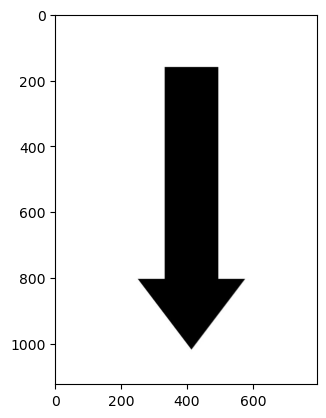

In [6]:
plt.imshow(ref_img)

In [7]:
svm = cv2.ml.SVM_load('trained_arrow_detection.yml')

In [8]:
def extract_convex_hull(img):
    good_values = None
    values = extract_good_values(img)

    for num, features in enumerate(values):
        ranges, angles = ranges_and_angles(features)
        prepared_values = np.concatenate((ranges, angles))
        try:
            result = svm.predict(np.matrix(prepared_values, dtype=np.float32))[1][0]
        except Exception as e:
            print(e)
            break

        if result == 1:
            good_values = features
    
    if good_values is None:
        raise ValueError('no good hull found')
    return good_values

In [9]:
hull = extract_convex_hull(ref_img)

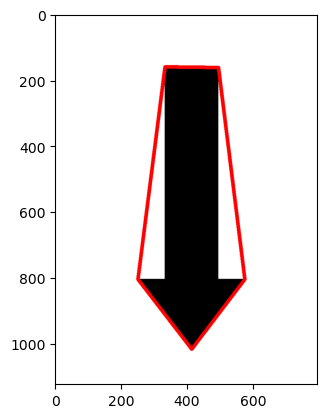

In [10]:
copy_img = ref_img.copy()
cv2.drawContours(copy_img, [hull], -1, (255, 0, 0), thickness=10)
plt.imshow(copy_img)

In [40]:
def prepare_rotation(min_rect):
    """
    Prepare portrait rotation. No difference between up and down.
    """
    
    width_to_height = min_rect[1][0] / min_rect[1][1]
    
    if width_to_height >= 1:
        return 90 - min_rect[2]
    else:
        return min_rect[2]    

In [12]:
def rotate_image(orig_image, angle):
    image = orig_image.copy()
    
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    
    #print(image_center)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    #rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    #print(result.shape)
    
    return result

### check rotations of minAreaRects

center (x,y), (width, height), angle of rotation<br>
10 deg

In [57]:
img_deg10 = rotate_image(ref_img, 10)

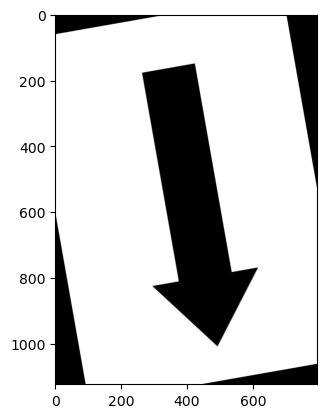

In [58]:
plt.imshow(img_deg10)

In [27]:
hull10 = extract_convex_hull(img_deg10)
min_rect10 = cv2.minAreaRect(hull10)
min_rect10

((444.5699157714844, 579.6414794921875),
 (858.2694702148438, 320.3096923828125),
 87.26529693603516)

In [13]:
ref_img.shape

(1123, 794, 3)

In [30]:
broad_ref_img = np.zeros((ref_img.shape[0], ref_img.shape[0], 3))
broad_ref_img = np.uint8(broad_ref_img)
offset = int((ref_img.shape[0] / 2) - (ref_img.shape[1] / 2))
print(offset)
print(offset+ref_img.shape[1])
broad_ref_img[:,offset:offset+ref_img.shape[1], :] = ref_img

164
958


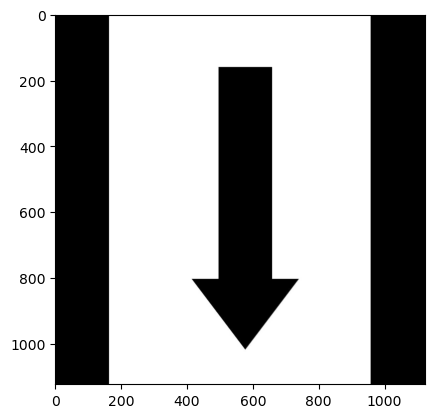

In [31]:
plt.imshow(broad_ref_img)

In [32]:
broad_ref_img.shape

(1123, 1123, 3)

80 deg

In [33]:
img_deg80 = rotate_image(broad_ref_img, 80)

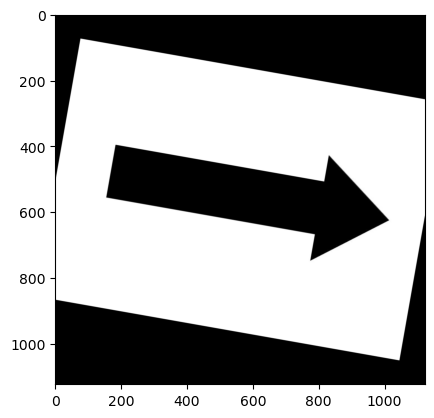

In [34]:
plt.imshow(img_deg80)

In [35]:
hull80 = extract_convex_hull(img_deg80)
min_rect80 = cv2.minAreaRect(hull80)
min_rect80

((595.104736328125, 522.9049072265625),
 (858.5745849609375, 321.1248779296875),
 17.43279266357422)

100 deg

In [60]:
img_deg100 = rotate_image(broad_ref_img, 100)

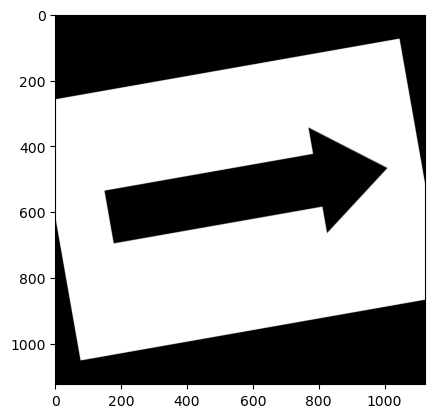

In [61]:
plt.imshow(img_deg100)

In [62]:
hull100 = extract_convex_hull(img_deg100)
min_rect100 = cv2.minAreaRect(hull100)
min_rect100

((580.1397705078125, 514.4140625),
 (320.3543395996094, 857.2686157226562),
 87.26950073242188)

170 deg

In [45]:
img_deg170 = rotate_image(ref_img, 170)

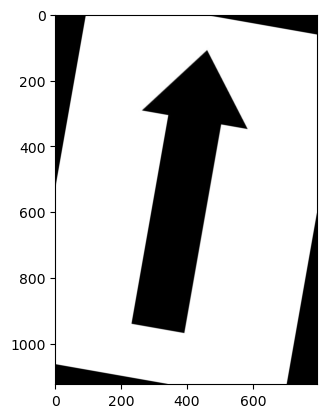

In [46]:
plt.imshow(img_deg170)

In [32]:
hull170 = extract_convex_hull(img_deg170)
min_rect170 = cv2.minAreaRect(hull170)
min_rect170

((358.1636962890625, 528.1437377929688),
 (321.1863708496094, 859.571533203125),
 17.34876823425293)

190 deg

In [48]:
img_deg190 = rotate_image(ref_img, 190)

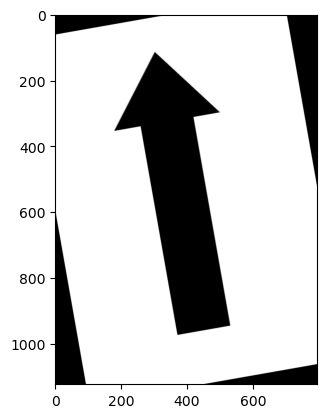

In [49]:
plt.imshow(img_deg190)

In [33]:
hull190 = extract_convex_hull(img_deg190)
min_rect190 = cv2.minAreaRect(hull190)
min_rect190

((349.4300842285156, 543.3585205078125),
 (858.2694702148438, 320.3096923828125),
 87.26529693603516)

260 deg

In [38]:
img_deg260 = rotate_image(broad_ref_img, 260)

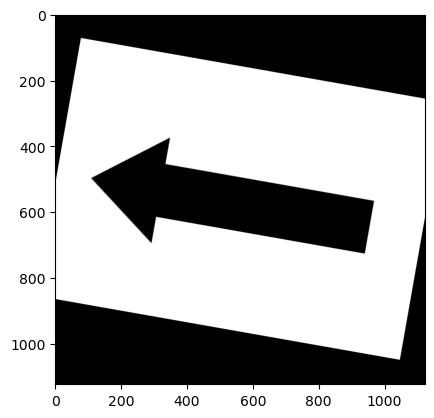

In [50]:
plt.imshow(img_deg260)

In [39]:
hull260 = extract_convex_hull(img_deg260)
min_rect260 = cv2.minAreaRect(hull260)
min_rect260

((527.895263671875, 600.0950927734375),
 (858.5745849609375, 321.1248779296875),
 17.43279266357422)

280 deg

In [40]:
img_deg280 = rotate_image(broad_ref_img, 280)

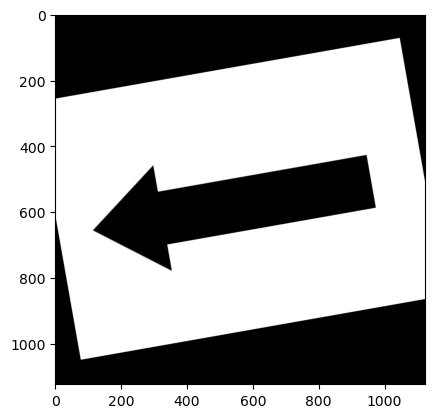

In [52]:
plt.imshow(img_deg280)

In [41]:
hull280 = extract_convex_hull(img_deg280)
min_rect280 = cv2.minAreaRect(hull280)
min_rect280

((542.8602294921875, 608.5859375),
 (320.3543395996094, 857.2686157226562),
 87.26950073242188)

350 deg

In [54]:
img_deg350 = rotate_image(ref_img, 350)

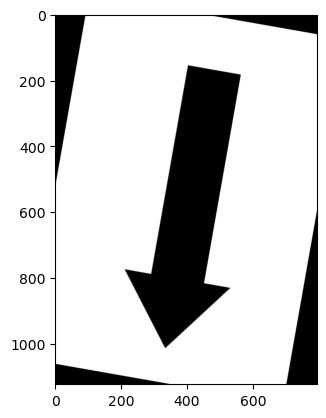

In [55]:
plt.imshow(img_deg350)

In [37]:
hull350 = extract_convex_hull(img_deg350)
min_rect350 = cv2.minAreaRect(hull350)
min_rect350

((435.8363952636719, 594.8563232421875),
 (321.1863708496094, 859.571533203125),
 17.34876823425293)

https://stackoverflow.com/questions/37177811/crop-rectangle-returned-by-minarearect-opencv-pythonrotation&emsp;rect angle&emsp;&emsp;&emsp;&emsp;&emsp;width and heigth<br>
10&ensp;&emsp;87.26529693603516&emsp;(858.2694702148438, 320.3096923828125)<br>
80&ensp;&emsp;17.43279266357422&emsp;(858.5745849609375, 321.1248779296875)<br>
100&emsp;87.26950073242188&emsp;(320.3543395996094, 857.2686157226562)<br>
170&emsp;17.34876823425293&emsp;(321.1863708496094, 859.571533203125)<br>
190&emsp;87.26529693603516&emsp;(858.2694702148438, 320.3096923828125)<br>
260&emsp;17.43279266357422&emsp;(858.5745849609375, 321.1248779296875)<br>
280&emsp;87.26950073242188&emsp;(320.3543395996094, 857.2686157226562)<br>
350&emsp;17.34876823425293&emsp;(321.1863708496094, 859.571533203125)

10&ensp;== 190 ? yes<br>
80&ensp;== 260 ? yes<br>
100 == 280 ? yes<br>
170 == 350 ? yes<br>
=> from 0 to 90

10 and 80 -> right up<br>
100 and 170 -> left up<br>
190 and 260 -> right up<br>
280 and 250 -> left up

portrait rot<br>
rotation&emsp;needed abs rotation<br>
10&ensp;&emsp;&emsp;&emsp;90-rot<br>
80&ensp;&emsp;&emsp;&emsp;90-rot<br>
100&emsp;&emsp;&emsp;rot<br>
170&emsp;&emsp;&emsp;rot<br>
190&emsp;&emsp;&emsp;90-rot<br>
260&emsp;&emsp;&emsp;90-rot<br>
280&emsp;&emsp;&emsp;rot<br>
350&emsp;&emsp;&emsp;rot<br>

relation of width/height and needed abs rotation!

# rescaling

In [11]:
ref_img.shape

(1123, 794, 3)

In [12]:
y, x, channel = ref_img.shape

In [21]:
y*32/x

45.259445843828715

In [22]:
small_ref_img = cv2.resize(ref_img, (32, 45))

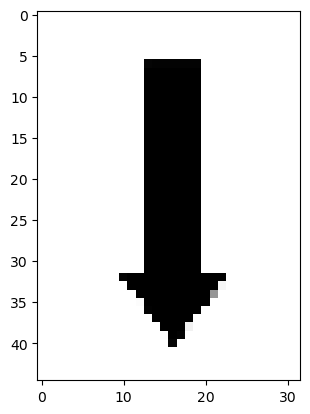

In [23]:
plt.imshow(small_ref_img)

In [97]:
test_img = cv2.imread('/home/me/Bilder/Bildschirmfotos/Bildschirmfoto vom 2023-09-10 20-07-58.png')

In [34]:
svm = cv2.ml.SVM_load('trained_arrow_detection.yml')

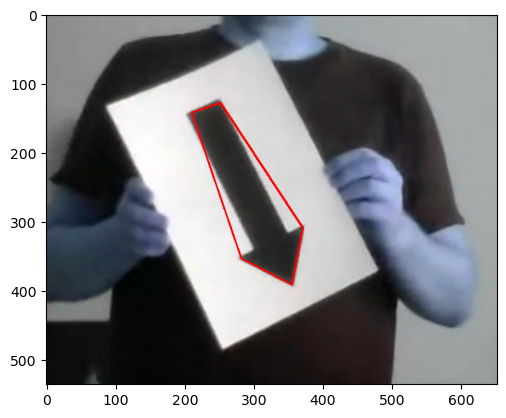

In [109]:
good_values = None
values = extract_good_values(test_img)

for num, features in enumerate(values):
    ranges, angles = ranges_and_angles(features)
    prepared_values = np.concatenate((ranges, angles))
    try:
        result = svm.predict(np.matrix(prepared_values, dtype=np.float32))[1][0]
    except Exception as e:
        print(e)
        break
        
    if result == 1:
        cv2.drawContours(test_img, values, num, (255, 0, 0), thickness=2)
        good_values = features
plt.imshow(test_img)

In [110]:
min_rect = cv2.minAreaRect(good_values)

In [113]:
box = cv2.boxPoints(min_rect)
box = np.intp(box)
#_ = cv2.drawContours(test_img,[box],0,(0,0,255),1)

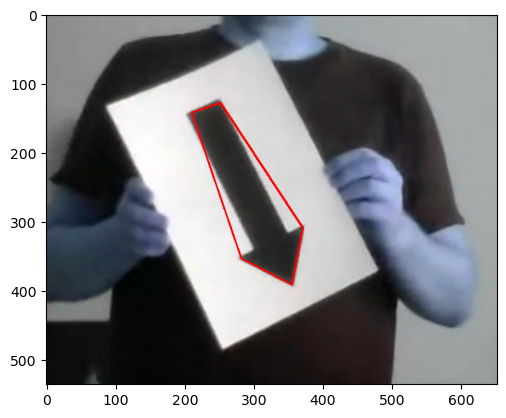

In [114]:
plt.imshow(test_img)

In [115]:
angle = prepare_rotation(min_rect)

In [116]:
angle

18.841293334960938

In [117]:
def rotate_and_crob_min_rect(image, min_area_rect, angle):
    box = cv2.boxPoints(min_area_rect)
    box = np.intp(box)

    height = round(min_area_rect[1][0])
    width = round(min_area_rect[1][1])
    
    size_of_transformed_image = max(min_area_rect[1])
#broad_ref_img = np.zeros((ref_img.shape[0], ref_img.shape[0], 3))
#broad_ref_img = np.uint8(broad_ref_img)
#offset = int((ref_img.shape[0] / 2) - (ref_img.shape[1] / 2))
#print(offset)
#print(offset+ref_img.shape[1])
#broad_ref_img[:,offset:offset+ref_img.shape[1], :] = ref_img
    x_coordinates_of_box = box[:,0]
    y_coordinates_of_box = box[:,1]
    x_min = min(x_coordinates_of_box)
    x_max = max(x_coordinates_of_box)
    y_min = min(y_coordinates_of_box)
    y_max = max(y_coordinates_of_box)

    rotated = False

    center = (int((x_min+x_max)/2), int((y_min+y_max)/2))
    size = (x_max-x_min, y_max-y_min)

    #size = (int(mult*(x2-x1)),int(mult*(y2-y1)))
    #cv2.circle(image, center, 10, (0,255,0), -1) #again this was mostly for debugging purposes

    cropped = cv2.getRectSubPix(image, size, center) 
    #plt.imshow(cropped)
    
    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), -angle, 1.0)

    cropped = cv2.warpAffine(cropped, M, size)
    plt.imshow(cropped)
    
    #print(width)
    #print(height)
    #print(size)
    #print(cropped.shape)
    
    croppedRotated = cv2.getRectSubPix(cropped, (width, height), (size[0]/2, size[1]/2))

    #plt.imshow(croppedRotated)
    #plt.show()
    return croppedRotated

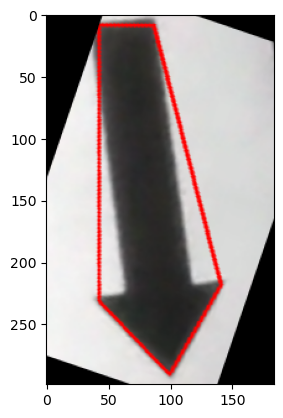

In [118]:
exact_arrow = rotate_and_crob_min_rect(test_img, min_rect, angle)

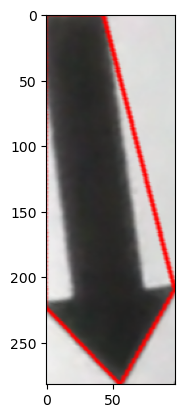

In [119]:
plt.imshow(exact_arrow)

a bit is missing

In [120]:
exact_arrow.shape

(282, 98, 3)

In [121]:
y, x, channel = exact_arrow.shape

In [142]:
x*64/y

22.24113475177305

In [145]:
small_test_img = cv2.resize(exact_arrow, (22, 64))

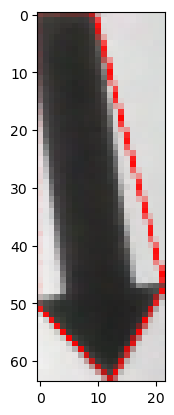

In [146]:
plt.imshow(small_test_img)

### test rotation of points

In [157]:
test_img = cv2.imread('/home/me/Bilder/Bildschirmfotos/Bildschirmfoto vom 2023-09-10 20-07-58.png')

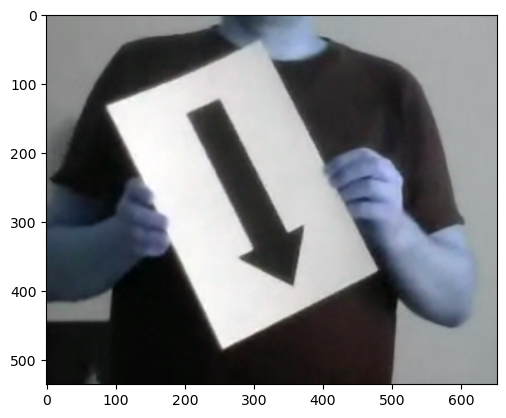

In [47]:
plt.imshow(test_img)

In [6]:
svm = cv2.ml.SVM_load('trained_arrow_detection.yml')

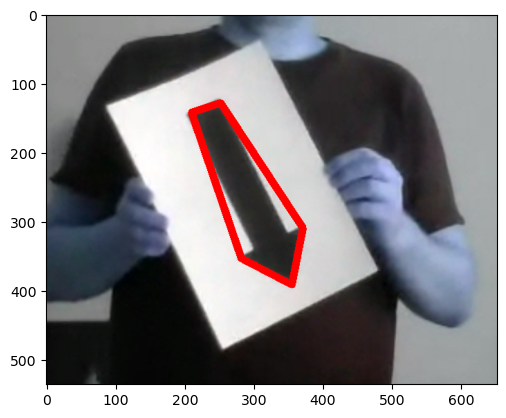

In [158]:
good_values = None
values = extract_good_values(test_img)

for num, features in enumerate(values):
    ranges, angles = ranges_and_angles(features)
    prepared_values = np.concatenate((ranges, angles))
    try:
        result = svm.predict(np.matrix(prepared_values, dtype=np.float32))[1][0]
    except Exception as e:
        print(e)
        break
        
    if result == 1:
        cv2.drawContours(test_img, values, num, (255, 0, 0), thickness=10)
        good_values = features
plt.imshow(test_img)

In [13]:
good_values

array([[210, 142],
       [252, 128],
       [371, 309],
       [355, 391],
       [282, 353]], dtype=int32)

In [5]:
# prepare_rotation

In [159]:
min_rect = cv2.minAreaRect(good_values)

In [160]:
min_rect

((302.197021484375, 259.77874755859375),
 (282.4851989746094, 98.4407958984375),
 71.15870666503906)

In [161]:
box = cv2.boxPoints(min_rect)
box = np.intp(box)
_ = cv2.drawContours(test_img,[box],0,(0,0,255),2)

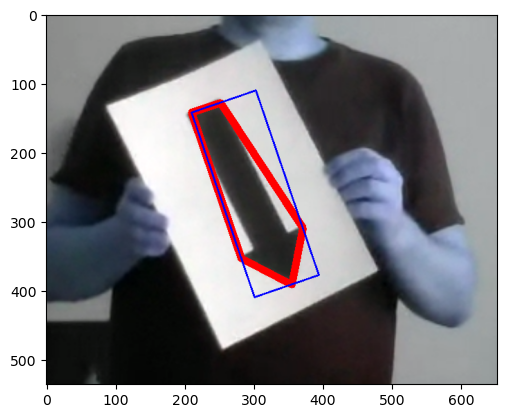

In [162]:
plt.imshow(test_img)

In [166]:
offset, rotation, shape_of_rect = prepare_rotation(min_rect)

In [167]:
print(offset)
print(rotation)
print(shape_of_rect)

(303.0, 110.0)
-18.841293334960938
(282.4851989746094, 98.4407958984375)


In [168]:
def rotate_and_crop_image(orig_image, offset, angle, left_shape):
    image = orig_image.copy()
    
    image_center = tuple(np.array(image.shape[1::-1]) / 2)
    
    y_start = int(offset[1])
    y_end = int(y_start + left_shape[0])
    x_start = int(offset[0])
    x_end = int(x_start + left_shape[1])
    #x_end = int(x_start)

    #print(y_start, y_end, x_start, x_end)
    point0 = (x_start, y_start)
    point1 = (x_start, y_end)
    point2 = (x_end, y_start)
    point3 = (x_end, y_end)
    point_mat = np.matrix((point0, point1, point2, point3)) - image_center
    point_mat = point_mat.transpose()
    
    print(point0, point1, point2, point3)
    cv2.circle(image, point0, 20, (250, 250,0), thickness=cv2.FILLED)
    #cv2.circle(image, point1, 20, (250, 250,0), thickness=cv2.FILLED)
    #cv2.circle(image, point2, 20, (250, 250,0), thickness=cv2.FILLED)
    #cv2.circle(image, point3, 20, (250, 250,0), thickness=cv2.FILLED)
    
    #print(image_center)
    rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
    #rot_mat = cv2.getRotationMatrix2D(center, angle, 1.0)
    result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_LINEAR)
    #print(result.shape)
    
    
    angle_in_rad = np.deg2rad(angle)
    rot_mat = np.matrix((
        (np.cos(angle_in_rad), np.sin(angle_in_rad)),
        (-np.sin(angle_in_rad), np.cos(angle_in_rad))
    ))
    
    
    #print(rot_mat)
    #print(point_mat)
    
    rotated_points = rot_mat * point_mat
    #print(rotated_points[0])
    rotated_points = rotated_points.transpose()
    #print(rotated_points[0])
    rotated_points = rotated_points + image_center
    rotated_points = rotated_points.astype(int)
    #print(rotated_points[0])
    
    #print(rotated_points)
    #print(rotated_points.shape)
    #print(result.shape)
    
    point_error = rotated_points[0]
    #print(point_error)
    #print(point_error[0])
    #print(point_error[0,0])
    
    point0 = (rotated_points[0,0], rotated_points[0,1])
    point1 = (rotated_points[1,0], rotated_points[1,1])
    point2 = (rotated_points[2,0], rotated_points[2,1])
    point3 = (rotated_points[3,0], rotated_points[3,1])
    print(point0, point1, point2, point3)
    
    #result = result[y_start:y_end, x_start:x_end, :]
    cv2.circle(result, point0, 20, (0, 255,0), thickness=cv2.FILLED)
    #cv2.circle(result, point1, 20, (0, 255,0), thickness=cv2.FILLED)
    #cv2.circle(result, point2, 20, (0, 255,0), thickness=cv2.FILLED)
    #cv2.circle(result, point3, 20, (0, 255,0), thickness=cv2.FILLED)
    return result

In [169]:
rotated_img = rotate_and_crop_image(test_img, center, rotation, shape_of_rect)

(303, 110) (303, 392) (401, 110) (401, 392)
(355, 111) (264, 377) (447, 142) (356, 409)


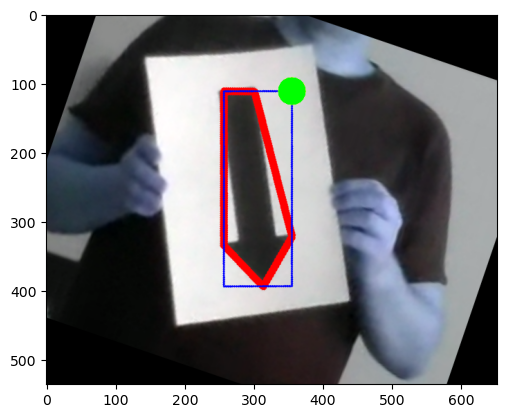

In [170]:
plt.imshow(rotated_img)

# svm opencv (svm.save for saving)

In [29]:
import cv2 as cv
import numpy as np
# Set up training data
labels = np.array([1, -1, -1, -1])
trainingData = np.matrix([[501, 10], [255, 10], [501, 255], [10, 501]], dtype=np.float32)
# Train the SVM
svm = cv.ml.SVM_create()
svm.setType(cv.ml.SVM_C_SVC)
svm.setKernel(cv.ml.SVM_LINEAR)
svm.setTermCriteria((cv.TERM_CRITERIA_MAX_ITER, 100, 1e-6))
svm.train(trainingData, cv.ml.ROW_SAMPLE, labels)
# Data for visual representation
width = 512
height = 512
image = np.zeros((height, width, 3), dtype=np.uint8)
# Show the decision regions given by the SVM
green = (0,255,0)
blue = (255,0,0)
for i in range(image.shape[0]):
    for j in range(image.shape[1]):
        sampleMat = np.matrix([[j,i]], dtype=np.float32)
        response = svm.predict(sampeMat)[1]
        response = response[0][0]
        
        if response == 1:
            image[i,j] = green
        elif response == -1:
            image[i,j] = blue
        else:
            import pdb
            pdb.set_trace()
        
#import pdb
#pdb.set_trace()
        
# Show the training data
thickness = -1
cv.circle(image, (501, 10), 5, ( 0, 0, 0), thickness)
cv.circle(image, (255, 10), 5, (255, 255, 255), thickness)
cv.circle(image, (501, 255), 5, (255, 255, 255), thickness)
cv.circle(image, ( 10, 501), 5, (255, 255, 255), thickness)
# Show support vectors
thickness = 2
sv = svm.getUncompressedSupportVectors()
for i in range(sv.shape[0]):
    cv.circle(image, (int(sv[i,0]), int(sv[i,1])), 6, (128, 128, 128), thickness)
    

#cv.imwrite('result.png', image) # save the image
cv.imshow('SVM Simple Example', image) # show it to the user
cv.waitKey()
cv.destroyAllWindows()

# image cropping example from stackoverflov
https://stackoverflow.com/questions/37177811/crop-rectangle-returned-by-minarearect-opencv-python

In [ ]:
im, contours, hierarchy = cv2.findContours(open_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
print("num of contours: {}".format(len(contours)))


mult = 1.2   # I wanted to show an area slightly larger than my min rectangle set this to one if you don't
img_box = cv2.cvtColor(img.copy(), cv2.COLOR_GRAY2BGR)
for cnt in contours:
    rect = cv2.minAreaRect(cnt)
    box = cv2.boxPoints(rect)
    box = np.int0(box)
    cv2.drawContours(img_box, [box], 0, (0,255,0), 2) # this was mostly for debugging you may omit

    W = rect[1][0]
    H = rect[1][1]

    Xs = [i[0] for i in box]
    Ys = [i[1] for i in box]
    x1 = min(Xs)
    x2 = max(Xs)
    y1 = min(Ys)
    y2 = max(Ys)

    rotated = False
    angle = rect[2]

    if angle < -45:
        angle+=90
        rotated = True

    center = (int((x1+x2)/2), int((y1+y2)/2))
    size = (int(mult*(x2-x1)),int(mult*(y2-y1)))
    cv2.circle(img_box, center, 10, (0,255,0), -1) #again this was mostly for debugging purposes

    M = cv2.getRotationMatrix2D((size[0]/2, size[1]/2), angle, 1.0)

    cropped = cv2.getRectSubPix(img_box, size, center)    
    cropped = cv2.warpAffine(cropped, M, size)

    croppedW = W if not rotated else H 
    croppedH = H if not rotated else W

    croppedRotated = cv2.getRectSubPix(cropped, (int(croppedW*mult), int(croppedH*mult)), (size[0]/2, size[1]/2))

    plt.imshow(croppedRotated)
    plt.show()

plt.imshow(img_box)
plt.show()